In [95]:
import importlib
import math
import time

import numpy as np
import pandas as pd

import skimage
from skimage.io import imread
from skimage import color
from skimage.transform import rescale, resize, downscale_local_mean

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt

import torch
import torchvision
from torch import nn
from torch.autograd import Variable
import torch.nn.functional as F
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d
from torch.optim import Adam
from torch.utils import data

import albumentations as albu

import natural_images_dataset_loader
from natural_images_dataset_loader import get_dataset_info, get_files_label_map, make_loaders

In [124]:
importlib.reload(natural_images_dataset_loader)
from natural_images_dataset_loader import get_dataset_info, get_files_label_map, make_loaders

In [3]:
%matplotlib inline

In [4]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [57]:
class NaturalImagesNet(nn.Module):
    
    def __init__(self, in_channels, classes_num):
        super(NaturalImagesNet, self).__init__()
        self.in_channels = in_channels
        self.conv0 = Conv2d(in_channels=in_channels, out_channels=in_channels, kernel_size=3, stride=1, padding=0)
        self.conv1 = Conv2d(in_channels=in_channels, out_channels=2 * in_channels, kernel_size=3, stride=1, padding=0)
        self.conv2 = Conv2d(in_channels=2 * in_channels, out_channels=in_channels, kernel_size=5, stride=1, padding=0)
        self.relu0 = ReLU()
        #self.fc2 = Linear(120 * 120 * in_channels, classes_num)
        #self.fc3 = Linear(126 * 126 * in_channels, classes_num) - for minimal net with relu - conv0, relu, fc3
        self.fc3 = Linear(120 * 120 * in_channels, classes_num)
        ####### Input img size 64x64
        #self.fc_out = Linear(62 * 62 * in_channels, classes_num)
        #self.fc0 = Linear(2 * 60 * 60 * in_channels, classes_num)
        #self.fc1 = Linear(56 * 56 * in_channels, classes_num)
        ######################
        
    def forward(self, x):        
        #print("forward: x.shape before conv0(x)", x.shape)
        x = self.conv0(x)
        x = self.relu0(x)
        x = self.conv1(x)
        #print("x.shape: ", x.shape)
        x = self.relu0(x)
        #print("forward: x.shape after conv0(x)", x.shape)
        #x = x.view(-1, 62 * 62 * self.in_channels)
        #x = x.view(-1, 2 * 62 * 62 * self.in_channels)
        
        x = self.conv2(x)
        #print("x.shape after self.conv2(x): ", x.shape)
        x = self.relu0(x)
        
        #x = x.view(-1, 2 * 60 * 60 * self.in_channels)        
        #x = self.fc0(x)
        
        #x = x.view(-1, 56 * 56 * self.in_channels)
        #x = self.fc1(x)
        
        #x = x.view(-1, 120 * 120 * self.in_channels)
        #x = self.fc2(x)
        
        #x = x.view(-1, 126 * 126 * self.in_channels)
        #x = self.fc3(x)
 
        x = x.view(-1, 120 * 120 * self.in_channels)
        x = self.fc3(x)
        #x = F.log_softmax(x, dim=1)
        #x = F.log_softmax(x)
        #x = self.fc_out(x)
        #print("forward, x after log_softmax:\n", x)
        return x

params = {'batch_size': 4, 'shuffle': True}
class_label_map = get_class_label_map('../input/natural-images/natural_images/*')

ni_ds_train = NaturalImagesDataset(class_label_map, resize_sizes=(64, 64))
ni_train_dataloader = data.DataLoader(ni_ds_train, **params)

ni_ds_valid = NaturalImagesDataset(class_label_map, valid=True, resize_sizes=(64, 64))
ni_valid_loader = data.DataLoader(ni_ds_valid, **params)

In [127]:
dataset_info = get_dataset_info('../input/natural-images/natural_images/*')
#print("len(dataset_info):", len(dataset_info))
#print("type(dataset_info[0][2]): ", type(dataset_info[0][2]))
#print("dataset_info[0][2][:10]: ", dataset_info[0][2][:10])
files_label_map = get_files_label_map(dataset_info)
#print(get_files_label_map(dataset_info)[2000:2020])
#print(type(make_loaders(files_label_map)))
train_dl, valid_dl, test_dl, fl_maps = make_loaders(
    files_label_map,
    train_test_split_ratio=0.25,
    train_valid_split_ratio=0.25,
    img_resize_sizes=(128, 128),
    transforms=(albu.Compose([albu.RandomRotate90()]), None, None),
    #transforms=(albu.RandomRotate90(), None, None),
    #transforms=(None, None, None)
)
#print(type(train_dl), type(valid_dl), type(test_dl))

In [7]:
classes_num = len(dataset_info)
print(classes_num)

8


In [8]:
input_channels = 3

In [128]:
learning_rate = 0.0001
#learning_rate = 0.001

In [129]:
#img, label = next(iter(ni_train_dataloader))
img, label = next(iter(train_dl))

__getitem__, self.transforms:  Compose([
  RandomRotate90(always_apply=False, p=0.5),
], p=1.0, bbox_params=None, keypoint_params=None, additional_targets={})
__getitem__, self.transforms:  Compose([
  RandomRotate90(always_apply=False, p=0.5),
], p=1.0, bbox_params=None, keypoint_params=None, additional_targets={})
__getitem__, self.transforms:  Compose([
  RandomRotate90(always_apply=False, p=0.5),
], p=1.0, bbox_params=None, keypoint_params=None, additional_targets={})
__getitem__, self.transforms:  Compose([
  RandomRotate90(always_apply=False, p=0.5),
], p=1.0, bbox_params=None, keypoint_params=None, additional_targets={})


In [11]:
type(img)
print(img.shape)

torch.Size([4, 3, 128, 128])


In [12]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [13]:
print("device: ", device)

device:  cuda:0


In [80]:
model = NaturalImagesNet(input_channels, classes_num)
#model = NaturalImagesNet()

In [81]:
model.to(device)

NaturalImagesNet(
  (conv0): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1))
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 3, kernel_size=(5, 5), stride=(1, 1))
  (relu0): ReLU()
  (fc3): Linear(in_features=43200, out_features=8, bias=True)
)

In [16]:
criterion = CrossEntropyLoss()

In [71]:
optimizer = Adam(model.parameters(), lr=learning_rate)

In [82]:
#num_of_epoch = 20
#num_of_epoch = 120
#num_of_epoch = 60
num_of_epoch = 20

train_losses = []
val_losses = []

start_time = time.time()

epoch_train_losses = []
epoch_val_losses = []

for epoch in range(num_of_epoch):
    # loop over the dataset multiple times
    
    avg_train_cost = 0
    avg_val_cost = 0
    
    train_running_loss = 0.0
    val_running_loss = 0.0
    
    one_epoch_train_losses = []
    one_epoch_val_losses = []
    for i, data in enumerate(train_dl, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs, labels = inputs.to(device, dtype=torch.float32), labels.to(device, dtype=torch.long)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        
        loss = criterion(outputs, labels)
        
        train_losses.append(loss)
        
        one_epoch_train_losses.append(loss)
        
        loss.backward()
        optimizer.step()

        # print statistics
        train_running_loss += loss.item()
        
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print("epoch: {}, batch: {} train running loss: {}".format(epoch, i, train_running_loss / 20))
            train_running_loss = 0.0
            
        avg_train_cost = avg_train_cost + loss.data
                
    if epoch % 2 != 0:
        print("epoch {}, avg train cost: {}".format(epoch, avg_train_cost))
        avg_train_cost = 0
        
    model.eval()
    with torch.no_grad():
        for i, data in enumerate(valid_dl, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            inputs, labels = inputs.to(device, dtype=torch.float32), labels.to(device, dtype=torch.long)
                
            outputs = model(inputs)
                
            val_loss = criterion(outputs, labels)
            val_losses.append(val_loss)
            one_epoch_val_losses.append(val_loss)
            val_running_loss += val_loss.item()
                
            if i % 2000 == 1999:    # print every 2000 mini-batches
                print("epoch: {}, batch: {} val running loss: {}".format(epoch, i, val_running_loss / 20))
                val_running_loss = 0.0
                
        avg_val_cost = avg_val_cost + loss.data
                
        if epoch % 2 != 0:
            print("epoch {}, avg val cost: {}".format(epoch, avg_val_cost))
            avg_val_cost = 0

    epoch_train_losses.append(one_epoch_train_losses)
    epoch_val_losses.append(one_epoch_val_losses)

    
avg_epoch_train_losses = [
    sum(one_epoch_train_loss) / len(one_epoch_train_loss) for one_epoch_train_loss in epoch_train_losses
]
avg_epoch_val_losses = [
    sum(one_epoch_val_loss) / len(one_epoch_val_loss) for one_epoch_val_loss in epoch_val_losses
]

print('Finished Training')
time_elapsed = time.time() - start_time
print(
    'Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60
    )
)

epoch 1, avg train cost: 2021.3375244140625
epoch 1, avg val cost: 2.0694375038146973
epoch 3, avg train cost: 2021.35546875
epoch 3, avg val cost: 2.1064419746398926
epoch 5, avg train cost: 2021.3465576171875
epoch 5, avg val cost: 2.0935537815093994
epoch 7, avg train cost: 2021.3353271484375
epoch 7, avg val cost: 2.0713701248168945
epoch 9, avg train cost: 2021.34814453125
epoch 9, avg val cost: 2.089707851409912
epoch 11, avg train cost: 2021.3360595703125
epoch 11, avg val cost: 2.0691640377044678
epoch 13, avg train cost: 2021.345458984375
epoch 13, avg val cost: 2.0891475677490234
epoch 15, avg train cost: 2021.349609375
epoch 15, avg val cost: 2.098489999771118
epoch 17, avg train cost: 2021.344970703125
epoch 17, avg val cost: 2.0893850326538086
epoch 19, avg train cost: 2021.328125
epoch 19, avg val cost: 2.0550365447998047
Finished Training
Training complete in 22m 59s


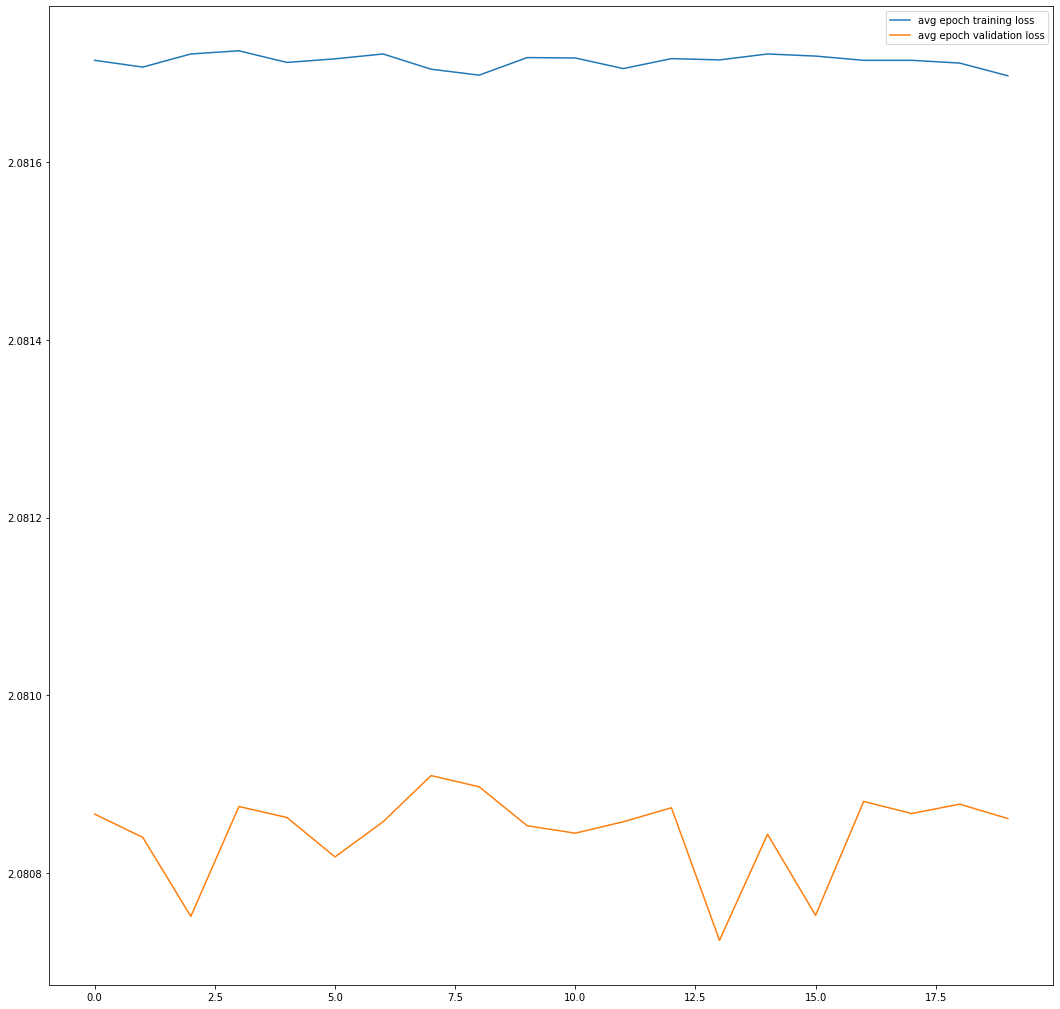

In [83]:
plt.figure(figsize=(18, 18))
plt.plot(avg_epoch_train_losses, label="avg epoch training loss")
plt.plot(avg_epoch_val_losses, label="avg epoch validation loss")
plt.legend()
plt.show()

In [ ]:
plt.plot(train_losses, label="Training loss")
plt.plot(val_losses, label="Validation loss")
plt.legend()
plt.show()

In [23]:
#x, y = Variable(train_x), Variable(train_y, requires_grad=False)

#pred = model(x)

#final_pred = np.argmax(pred.data.numpy(), axis=1)

#accuracy_score(train_y, final_pred)

In [24]:
#PATH = './my_first_model_1_with_1_conv_layers_1_fc_lapyer_maximal_smple.pth'
#torch.save(model.state_dict(), PATH)

In [20]:
dataiter = iter(valid_dl)
images, labels = dataiter.next()

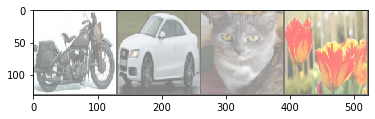

In [21]:
#print images
imshow(torchvision.utils.make_grid(images))
#print('GroundTruth: ', ' '.join('%5s' % class_label_map[labels[j]] for j in range(4)))

In [22]:
#model0 = NaturalImagesNet()
#model0.load_state_dict(torch.load(PATH))

In [25]:
images = images.to(device, dtype=torch.float32)

In [26]:
#outputs = model0(images)
outputs = model(images)

x.shape after self.conv2(x):  torch.Size([4, 3, 120, 120])


In [ ]:
#_, predicted = torch.max(outputs, 1)

#print('Predicted: ', ' '.join('%5s' % class_label_map[predicted[j]]
#                              for j in range(4)))

In [78]:
correct = 0
total = 0
with torch.no_grad():
    for data in test_dl:
        images, labels = data
        outputs = model(images.to(device, dtype=torch.float32))
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels.to(device)).sum().item()

print("Accuracy of the network on the test images: %d %%" % (100 * correct / total))

Accuracy of the network on the test images: 10 %


In [ ]:
class_correct = list(0. for i in range(8))
class_total = list(0. for i in range(8))
with torch.no_grad():
    for data in test_dl:
        images, labels = data
        labels = labels.to(device)learning_rate = 0.00001
        outputs = model(images.to(device, dtype=torch.float32))
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        #for i in range(4):
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(8):
    print('Accuracy of %5s : %2d %%' % (
        dataset_info[i][0], 100 * class_correct[i] / class_total[i]))

In [ ]:
Accuracy of flower : 43 %
Accuracy of   cat : 55 %
Accuracy of   dog : 26 %
Accuracy of fruit : 95 %
Accuracy of motorbike : 74 %
Accuracy of   car : 72 %
Accuracy of person : 95 %
Accuracy of airplane : 74 %

In [ ]:
Accuracy of flower : 79 %
Accuracy of   cat : 50 %
Accuracy of   dog : 31 %
Accuracy of fruit : 99 %
Accuracy of motorbike : 84 %
Accuracy of   car : 81 %
Accuracy of person : 97 %
Accuracy of airplane : 86 %

In [ ]:
With two conv layers conv0 and conv1 without relu0 layer and with fc0 layer
Accuracy of flower : 46 %
Accuracy of   cat : 38 %
Accuracy of   dog : 26 %
Accuracy of fruit : 98 %
Accuracy of motorbike : 67 %
Accuracy of   car : 62 %
Accuracy of person : 94 %
Accuracy of airplane : 75 %
Accuracy of the network on the test images: 65 %

In [ ]:
With one conv and one relu layers and fc_out layer
Accuracy of flower : 71 %
Accuracy of   cat : 48 %
Accuracy of   dog : 35 %
Accuracy of fruit : 99 %
Accuracy of motorbike : 82 %
Accuracy of   car : 76 %
Accuracy of person : 97 %
Accuracy of airplane : 85 %
Accuracy of the network on the test images: 75 %

In [ ]:
Maximal simple network with one conv and one fc layers - conv0 and fc_out
Accuracy of flower : 52 %
Accuracy of   cat : 46 %
Accuracy of   dog : 27 %
Accuracy of fruit : 98 %
Accuracy of motorbike : 70 %
Accuracy of   car : 65 %
Accuracy of person : 97 %
Accuracy of airplane : 71 %
Accuracy of the network on the test images: 67 %

In [ ]:
Maximal simple network with one conv and one fc layers - conv0 and fc_out learning_rate = 0.001 epoch = 12
Accuracy of flower : 60 %
Accuracy of   cat : 63 %
Accuracy of   dog : 22 %
Accuracy of fruit : 99 %
Accuracy of motorbike : 79 %
Accuracy of   car : 75 %
Accuracy of person : 98 %
Accuracy of airplane : 88 %
Accuracy of the network on the test images: 74 %

In [ ]:
Maximal simple network with one conv and one fc layers - conv0 and fc_out learning_rate = 0.001 epoch = 36
Accuracy of flower : 62 %
Accuracy of   cat : 64 %
Accuracy of   dog : 18 %
Accuracy of fruit : 99 %
Accuracy of motorbike : 75 %
Accuracy of   car : 69 %
Accuracy of person : 96 %
Accuracy of airplane : 76 %
Accuracy of the network on the test images: 72 %

In [ ]:
Maximal simple network with one conv and one fc layers - conv0 and fc_out learning_rate = 0.0009 epoch = 12
Accuracy of flower : 45 %
Accuracy of   cat : 53 %
Accuracy of   dog : 22 %
Accuracy of fruit : 96 %
Accuracy of motorbike : 73 %
Accuracy of   car : 62 %
Accuracy of person : 94 %
Accuracy of airplane : 78 %
Accuracy of the network on the test images: 67 %

In [ ]:
Maximal simple network with one conv and one fc layers - conv0 and fc_out learning_rate = 0.001 epoch = 12
Accuracy of flower : 57 %
Accuracy of   cat : 50 %
Accuracy of   dog : 21 %
Accuracy of fruit : 99 %
Accuracy of motorbike : 68 %
Accuracy of   car : 70 %
Accuracy of person : 96 %
Accuracy of airplane : 66 %
Accuracy of the network on the test images: 68 %